# Read data in + EDA

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

user_artists = pd.read_csv('./Data/user_artists.dat', sep='\t',
                           names=['userID', 'artistID', 'listen_count'], skiprows=1)
artists = pd.read_csv('./Data/artists.dat', sep='\t',
                      names=['artistID', 'name', 'url', 'pictureURL'],
                      encoding='latin-1', skiprows=1)

tags = pd.read_csv('./Data/tags.dat', sep='\t', names=['tagID', 'tagValue'], encoding='latin-1', skiprows=1)
user_tagged = pd.read_csv('./Data/user_taggedartists.dat', sep='\t',
                          names=['userID', 'artistID', 'tagID'], skiprows=1)

artist_tag = user_tagged.merge(tags, on='tagID', how='left')


Number of users: 1892
Number of artists: 17632
Number of interactions: 92834
Sparsity: 0.9972

Top 20 Artists by Total Listens:
            Artist  Total Listens
    Britney Spears        2393140
      Depeche Mode        1301308
         Lady Gaga        1291387
Christina Aguilera        1058405
          Paramore         963449
           Madonna         921198
           Rihanna         905423
           Shakira         688529
       The Beatles         662116
        Katy Perry         532545
     Avril Lavigne         525844
      Taylor Swift         525292
       Evanescence         513476
         Glee Cast         506453
          BeyoncÃ©         499318
                U2         493024
       Miley Cyrus         489065
30 Seconds to Mars         485532
              Muse         485076
        Pink Floyd         466104


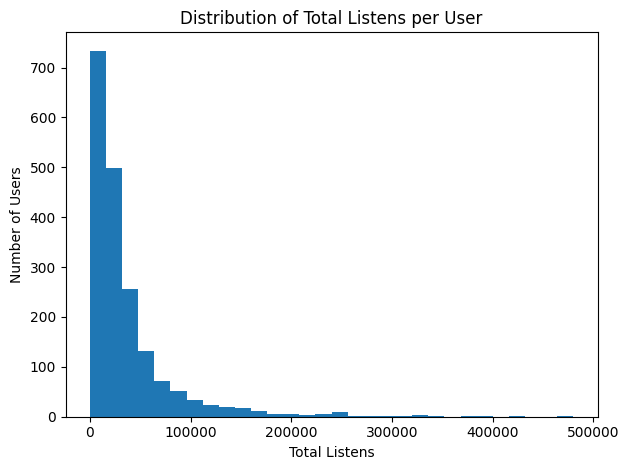

In [6]:
n_users = user_artists['userID'].nunique()
n_artists = user_artists['artistID'].nunique()
n_interactions = len(user_artists)
sparsity = 1 - (n_interactions / (n_users * n_artists))

ua = user_artists.merge(artists[['artistID', 'name']], on='artistID', how='left')

top_artists = ua.groupby('name')['listen_count'].sum().sort_values(ascending=False).head(20).reset_index()

listens_per_user = user_artists.groupby('userID')['listen_count'].sum()

print(f"Number of users: {n_users}")
print(f"Number of artists: {n_artists}")
print(f"Number of interactions: {n_interactions}")
print(f"Sparsity: {sparsity:.4f}")

top_artists_table = top_artists.copy()
top_artists_table.columns = ['Artist', 'Total Listens']
print("\nTop 20 Artists by Total Listens:")
print(top_artists_table.to_string(index=False))

plt.figure()
plt.hist(listens_per_user, bins=30)
plt.title('Distribution of Total Listens per User')
plt.xlabel('Total Listens')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

Total unique tags: 11946
Total tag applications: 186479
Unique artist‐tag pairs: 73
Artists with ≥1 tag: 12


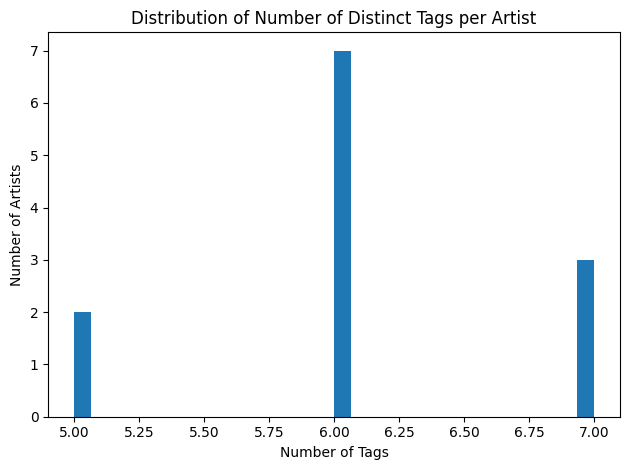

In [7]:
n_tags = tags['tagID'].nunique()
n_tag_apps = len(artist_tag)
n_unique_artist_tags = artist_tag[['artistID', 'tagID']].drop_duplicates().shape[0]
n_artists_with_tags = artist_tag['artistID'].nunique()

top_tags = tag_counts = (artist_tag.groupby('tagValue')
                         .size()
                         .sort_values(ascending=False)
                         .head(20)
                         .reset_index(name='count'))

print(f"Total unique tags: {n_tags}")
print(f"Total tag applications: {n_tag_apps}")
print(f"Unique artist‐tag pairs: {n_unique_artist_tags}")
print(f"Artists with ≥1 tag: {n_artists_with_tags}")

tags_per_artist = artist_tag.groupby('artistID')['tagID'].nunique()
plt.figure()
plt.hist(tags_per_artist, bins=30)
plt.title('Distribution of Number of Distinct Tags per Artist')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Artists')
plt.tight_layout()
plt.show()

# Preprocess - will limit to users & artists with at least 20 listens

In [8]:
user_counts = ua.groupby('userID').size()
artist_counts = ua.groupby('artistID').size()
valid_users = user_counts[user_counts >= 20].index
valid_artists = artist_counts[artist_counts >= 20].index

filtered = ua[ua['userID'].isin(valid_users) & ua['artistID'].isin(valid_artists)]

user_item_matrix = filtered.pivot_table(
    index='userID', columns='artistID', values='listen_count', fill_value=0
)

In [9]:
missing_total = user_item_matrix.isna().sum().sum()

num_users = user_item_matrix.shape[0]
num_artists = user_item_matrix.shape[1]

print(f"Number of users: {num_users}")
print(f"Number of artists: {num_artists}")
print(f"Missing summary: {missing_total}") 

Number of users: 1847
Number of artists: 804
Missing summary: 0


In [10]:
# save dataset

user_item_matrix.to_csv('./Data/preprocessed_user_item_matrix.csv')


# Some modeling attempts

In [24]:
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler

def train_test_split(obs_df, test_frac=0.2, random_state=42):
    np.random.seed(random_state)
    is_test = obs_df.groupby('userID').apply(
        lambda df: df.sample(frac=test_frac, random_state=random_state).index
    ).explode()

    test_idx = set(is_test)
    train_df = obs_df.drop(index=test_idx)
    test_df  = obs_df.loc[list(test_idx)]
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [25]:

n_users_sub = 100
n_artists_sub = 100
np.random.seed(42)
users = np.random.choice(user_item_matrix.index, n_users_sub, replace=False)
artists = np.random.choice(user_item_matrix.columns, n_artists_sub, replace=False)
sub_matrix = user_item_matrix.loc[users, artists]

obs = sub_matrix.stack().reset_index()
obs.columns = ['userID', 'artistID', 'listen_count']

# Log-transform the counts
obs['log_count'] = np.log1p(obs['listen_count'])

# Standardize log counts
scaler = StandardScaler()
obs['y_scaled'] = scaler.fit_transform(obs[['log_count']])

obs['u_idx'] = obs['userID'].astype('category').cat.codes
obs['a_idx'] = obs['artistID'].astype('category').cat.codes

train_obs, test_obs = train_test_split(obs, test_frac=0.2)

counts = train_obs['y_scaled'].values
u_idx = train_obs['u_idx'].values
a_idx = train_obs['a_idx'].values

In [28]:
n_latent = 3
with pm.Model() as bpmf_nuts:
    U = pm.Normal('U', 0, 1, shape=(n_users_sub, n_latent))
    V = pm.Normal('V', 0, 1, shape=(n_artists_sub, n_latent))
    sigma = pm.HalfNormal('sigma', 1)

    mu = pm.math.sum(U[u_idx] * V[a_idx], axis=1)
    pm.Normal('R_obs', mu=mu, sigma=sigma, observed=counts)

    trace_nuts = pm.sample(draws=1000, tune=2000, chains=4, target_accept=0.95, cores=4, return_inferencedata=True)

print(az.summary(trace_nuts, var_names=['sigma']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [U, V, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 254 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sigma  0.867  0.007   0.853     0.88        0.0      0.0    3877.0    2970.0   

       r_hat  
sigma    1.0  


Divergences: 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.867,0.007,0.853,0.880,0.000,0.000,3877.0,2970.0,1.00
"U[0, 0]",0.546,1.156,-1.669,2.118,0.380,0.156,10.0,24.0,1.32
"U[0, 1]",0.029,1.115,-1.698,1.951,0.277,0.072,18.0,89.0,1.17
"U[0, 2]",-0.019,0.948,-1.649,1.725,0.173,0.076,31.0,84.0,1.13
"U[1, 0]",0.323,0.773,-1.132,1.480,0.252,0.095,10.0,33.0,1.31
...,...,...,...,...,...,...,...,...,...
"V[98, 1]",-0.007,0.173,-0.334,0.309,0.026,0.003,43.0,688.0,1.06
"V[98, 2]",-0.005,0.166,-0.322,0.298,0.025,0.003,43.0,510.0,1.06
"V[99, 0]",-0.039,0.169,-0.354,0.281,0.024,0.004,50.0,419.0,1.05
"V[99, 1]",0.009,0.170,-0.309,0.330,0.017,0.003,95.0,554.0,1.03


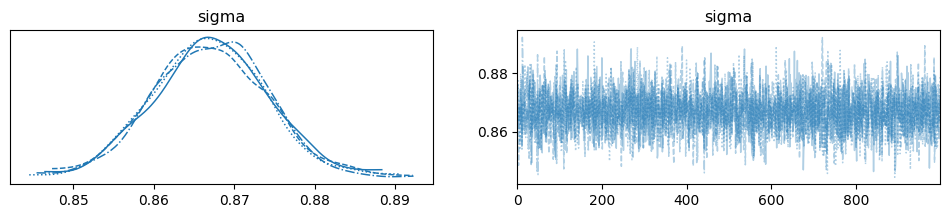

In [29]:
print("Divergences:", trace_nuts.sample_stats['diverging'].sum().values)
az.plot_trace(trace_nuts, var_names=['sigma'])
az.summary(trace_nuts, var_names=['sigma','U','V'])


In [30]:
# make predictions

# 1. Posterior means
U_mean = trace_nuts.posterior['U'].mean(dim=('chain','draw')).values  
V_mean = trace_nuts.posterior['V'].mean(dim=('chain','draw')).values 

# 2. Full score matrix
R_hat = U_mean @ V_mean.T

user_map   = {userID: idx for idx, userID in enumerate(sub_matrix.index)}
artist_map = {artistID: idx for idx, artistID in enumerate(sub_matrix.columns)}

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test_obs['y_scaled'].values
y_pred = np.array([
    R_hat[user_map[row.userID], artist_map[row.artistID]]
    for _, row in test_obs.iterrows()
])

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"Test MSE: {mse:.3f}, MAE: {mae:.3f}")


Test MSE: 0.996, MAE: 0.373
